In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#from pyaedt.hfss import Hfss
from ansys.aedt.core import Hfss
import os, copy, pprint, math
import numpy as np
import matplotlib.pyplot as plt
from tqdm.contrib import tenumerate
from tqdm import tqdm

from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / 'util/'))

from functions import *
from devices import *

## Configuration

In [3]:
config = load_config( "config/Cavity_Qubit5G.yaml" )

pprint.pprint(config)
options = config["solution"]["options"]

{'parameter': {'$cavity_height': '28mm',
               '$cavity_length': '7mm',
               '$cavity_width': '30mm',
               '$chip_gap': '20um',
               '$chip_height': '400um',
               '$chip_inductance': '1.4nH',
               '$chip_pos_x': '0',
               '$chip_pos_y': '0',
               '$chip_pos_z': '$chip_pos_z_ratio*$cavity_height',
               '$chip_pos_z_ratio': '0.5',
               '$chip_theta': '0deg',
               '$chip_width': '250um',
               '$port_distance': '12mm',
               '$port_height': '7mm',
               '$port_in_depth': '4mm',
               '$port_inner_radius': '0.3mm',
               '$port_out_depth': '6.5mm',
               '$port_outer_radius': '2.1mm',
               '$wafer_height': '0.95*$cavity_length',
               '$wafer_thickness': '0.525mm',
               '$wafer_width': '2mm'},
 'solution': {'name': 'Cavity5G',
              'options': {'SaveFields': True,
                          'ad

In [4]:
if len(config["sweep"]["list"][config["solution"]["type"]]) == 0:
    no_variation = False
else:
    no_variation = True

## Make project and design

In [5]:
hfss = Hfss(
    project       = "test.aedt",
    design        = "A1",
    solution_type = config["solution"]["type"]
)
hfss.logger.logger.setLevel("WARNING")
hfss.modeler.logger.logger.setLevel("WARNING")

PyAEDT INFO: Python version 3.11.13 | packaged by conda-forge | (main, Jun  4 2025, 14:39:58) [MSC v.1943 64 bit (AMD64)].
PyAEDT INFO: PyAEDT version 0.17.4.
PyAEDT INFO: Initializing new Desktop session.
PyAEDT INFO: Log on console is enabled.
PyAEDT INFO: Log on file C:\Users\ymino\AppData\Local\Temp\15\pyaedt_ymino_6f5c0939-b6e6-4f2f-8a13-c4f13ae44640.log is enabled.
PyAEDT INFO: Log on AEDT is disabled.
PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.
PyAEDT INFO: Launching PyAEDT with gRPC plugin.
PyAEDT ERROR: A(n) <class 'psutil.AccessDenied'> error occurred while retrieving information for the active AEDT sessions: (pid=11984, name='ansysedt.exe')
PyAEDT ERROR: A(n) <class 'psutil.AccessDenied'> error occurred while retrieving information for the active AEDT sessions: (pid=13016, name='ansysedt.exe')
PyAEDT ERROR: A(n) <class 'psutil.AccessDenied'> error occurred while retrieving information for the active AEDT sessions: (pid=16452, name='ansysedt.exe'

## Create Objects

In [6]:
device_BoxCavity(hfss, config)

## Create Analysis Setup

In [7]:
create_setup(hfss, config)


{'BasisOrder': 1,
 'DoLambdaRefine': True,
 'DoMaterialLambda': True,
 'Frequency': '7.5GHz',
 'IE Solver Accuracy': 'Balanced',
 'IESolverType': 'Auto',
 'IsEnabled': True,
 'LambdaTargetForIESolver': 0.15,
 'MaxDeltaS': 0.02,
 'MaximumPasses': 20,
 'MeshLink': {'ImportMesh': False},
 'MinimumConvergedPasses': 1,
 'MinimumPasses': 1,
 'MultipleAdaptiveFreqsSetup': {'1GHz': [0.02], '2GHz': [0.02], '5GHz': [0.02]},
 'Name': 'Cavity5G',
 'PercentRefinement': 30,
 'PortAccuracy': 2,
 'PortsOnly': False,
 'SaveAnyFields': True,
 'SaveRadFieldsOnly': False,
 'SetLambdaTarget': False,
 'SetPortMinMaxTri': False,
 'SolveType': 'Single',
 'Target': 0.3333,
 'UseABCOnPort': False,
 'UseDefaultLambdaTgtForIESolver': True,
 'UseDomains': False,
 'UseIterativeSolver': False,
 'UseMatrixConv': False,
 'UseMaxTetIncrease': False}


## Optimetrics

In [8]:
sweep = create_sweep(hfss, config)

## Analyze

In [9]:
if not no_variation:
    hfss.analyze_setup(name = config["solution"]["name"], cores=8)
else:
    ## You can check the available properties
    # print(sweep.props)
    ## If you want to enable SaveFields & CopyMesh, you need to directly rewrite the properties using the dictionary
    # hfss.set_oo_property_value(
    #     aedt_object=hfss.ooptimetrics, 
    #     object_name="ChipInductance", 
    #     prop_name='SaveFields', 
    #     value='True')
    print(sweep)
    sweep.props["ProdOptiSetupDataV2"]["SaveFields"] = options["SaveFields"]
    if config["solution"]["type"] == "Eigenmode":
        sweep.props["ProdOptiSetupDataV2"]["CopyMesh"] = options["copy_mesh"]
    sweep.analyze(cores = 8)

## Produce Report

In [10]:
if config["solution"]["type"] == "Modal":
    report_config = dict(
        expressions=["db(S12)"], 
        #expressions=["db(S(Port_out,Port_in))","db(S(Port_out1,Port_in))"], 
        plot_name="S-parameter", 
        variations={
            "Freq": ["All"],
        }
    )
    if options["n_waveport_mode"] >= 2:
        expressions = []
        for i in range(options["n_waveport_mode"]):
            expressions.append(f"db(S(Port_out,Port_in:{i+1}))")
        report_config.update(
            expressions = expressions
        )
else:
    report_config = dict(
        # expressions=["Mode(1)","Mode(2)","Mode(3)"], 
        plot_name="Eigen modes", 
        variations={}
    )

# Add variations to report_config
for var in config["sweep"]["list"][config["solution"]["type"]]:
    report_config["variations"][var] = ["All"]

report = hfss.post.create_report( **report_config )

In [11]:
# traces_to_plot = hfss.get_traces_for_plot()
# report = hfss.post.create_report(traces_to_plot)  # Creates a report in HFSS
# solution = report.get_solution_data()
# solution.plot(solution.expressions[1])  # Matplotlib axes object.

['db(S12)']


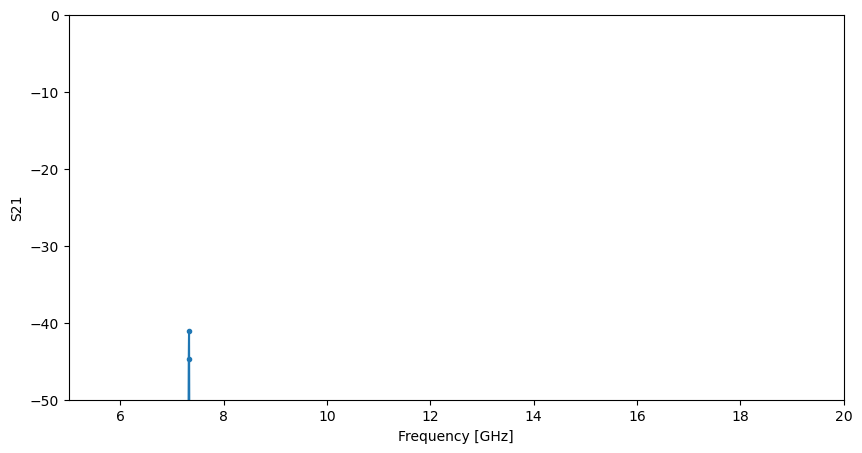

In [12]:
if config["solution"]["type"] == "Modal":
    expressions=["db(S(Port_out,Port_in))"]
    
    # report = hfss.post.reports_by_category.eigenmode(expressions=expressions)
    solution_data = report.get_solution_data()
    solution_data.export_data_to_csv(output="output/CoaxCavity_Modal.csv")
    # Get S21 data
    print(report.expressions)

    # Get frequency list
    freq_list = [ i.value for i in solution_data.variation_values(variation="Freq") ]

    if not no_variation:
        S = solution_data.data_real()
        plt.figure(figsize=(10,5))
        plt.subplot(111, xlabel = "Frequency [GHz]", ylabel = "S21")
        plt.plot(freq_list, S, marker = ".")
        plt.xlim(5,20)
        plt.ylim(-50,0)
    else:
        print(solution_data.variations)
        mode_S_array = np.zeros(shape=(len(solution_data.variations), len(freq_list)))
    

        # First retrieve all information
        if options["n_waveport_mode"] == 2:
            # If there are two modes, add S-parameters
            for id in tqdm(range(len(solution_data.variations))):
                solution_data.set_active_variation(id)
                power_array = np.zeros(shape=(1, len(freq_list)))
                for expr in report.expressions:
                    # print(id, expr, solution_data.data_real(expression=expr))
                    power_array += np.power(10, 0.1*np.array(solution_data.data_real(expression=expr)))
                mode_S_array[id] = 10*np.log10(power_array)
        else:
            for id in tqdm(range(len(solution_data.variations))):
                solution_data.set_active_variation(id)
                mode_S_array[id] = solution_data.data_real()

        # plt.figure(figsize=(10,5))
        # plt.subplot(111, xlabel = "Frequency [GHz]", ylabel = "S21")
        # for id, var in enumerate(solution_data.variations):
        #     plt.plot(freq_list, mode_S_array[id], marker = ".", label = var.values())
        # plt.xlim(10,20)
        # plt.ylim(-70,0)
        # plt.legend(loc = "lower right")

        # Find variation with least loss between 12 ~ 20 GHz
        average_list = []
        # for id, var in enumerate(solution_data.variations):
        for id, var in tenumerate(solution_data.variations):
            total = 0
            point = 0
            for freq, S21 in zip(freq_list, mode_S_array[id]):
                if 12 < freq and freq < 20:
                    total += S21
                    point += 1
            average = float(total/point)
            average_list.append(average)

        # max_index = np.argmax(average_list)
        # print(average_list[max_index])
        # print(solution_data.variations[max_index])

        num = 8 # Number of variations to show

        sorted_indices = sorted(range(len(average_list)), key=lambda i: average_list[i], reverse=True)
        for i, id in enumerate(sorted_indices):
            print(average_list[id], solution_data.variations[id])
            if i == num - 1:
                break

        plt.figure(figsize=(10,5))
        plt.subplot(111, xlabel = "Frequency [GHz]", ylabel = "S21")

        for i, id in enumerate(sorted_indices):
            var = solution_data.variations[id]
            plt.plot(freq_list, mode_S_array[id], marker = ".", label = var.values())
            if i == num - 1:
                break
        plt.xlim(10,20)
        plt.ylim(-40,0)
        plt.legend( bbox_to_anchor=(0., 1.05), loc = "lower left")

        for x_var in solution_data.variations[0]:
            x = {}
            y = {}
            for id, vars in tenumerate(solution_data.variations):  
                key = ""
                for var in vars:
                    if var == x_var:
                        x_value = vars[x_var].value
                    else:
                        key += rename_var(vars, var) + ", "
                if key not in x:
                    x[key] = []
                    y[key] = []
                # x[key].append( pos_z_ratio )
                x[key].append( x_value )
                y[key].append( average_list[id] )

            # Use the list to select top rows
            top_keys = []
            for i, id in enumerate(sorted_indices):
                vars = solution_data.variations[id]
                key = ""
                for var in vars:
                    if var == x_var:
                        pass
                    else:
                        key += rename_var(vars, var)  + ", "
                top_keys.append(key)
                if i == num - 1:
                    break

            plt.rcParams["font.size"] = 16
            plt.figure(figsize=(6,5))

            marker_map = [
                'o', '^', 's'
            ]
            for i, key in enumerate(x):
                if key in top_keys:
                    plt.plot(x[key], y[key], marker = marker_map[i%3], label = key, linewidth=3, markersize=8)
                    plt.xlabel(x_var)
            # plt.ylim(-30,0)
            # plt.legend(loc = "lower left", fontsize="large")
            plt.legend( bbox_to_anchor=(0, 1.05), loc='lower left' )
            plt.savefig('output/sweep_' + x_var.replace('$','') + '.png', bbox_inches='tight')

In [13]:
solution_data = report.get_solution_data()
for id in range(len(solution_data.variations)):
    print(solution_data.variations[id])
    solution_data.set_active_variation(id)

{}


In [14]:
if config["solution"]["type"] == "Eigenmode":
    # report = hfss.post.reports_by_category.eigenmode(expressions=expressions)
    solution_data = report.get_solution_data()
    solution_data.export_data_to_csv(output="output/CoaxCavity_Eigenmode.csv")

    max_freq_list = []
    max_Q_list = []
    next_freq_list = []
    next_Q_list = []
    mode_freq_array = np.zeros(shape=(len(report.expressions), len(solution_data.variations)))
    mode_Q_array = np.zeros(shape=(len(report.expressions), len(solution_data.variations)))

    # First retrieve all information
    for id in range(len(solution_data.variations)):
         solution_data.set_active_variation(id)
         for imode, mode in enumerate(report.expressions):
            freq = solution_data.data_real(mode)[0]
            Q = abs(0.5 * freq / solution_data.data_imag(mode)[0])
            # if solution_data.data_imag(mode)[0] > 0:
            #     Q = abs(0.5 * freq / solution_data.data_imag(mode)[0])
            # else:
            #     Q = 1e+11
            mode_freq_array[imode][id] = freq
            mode_Q_array[imode][id] = Q
    # Get unrelated mode info
    if options["copy_mesh"]:
        tol = 0.1e+9
    else:
        tol = 0.05e+9
    flat = mode_freq_array.flatten()
    groups = []
    averages = []
    used = set()

    min_count = int(0.8*len(solution_data.variations))
    for i, val in enumerate(flat):
        if i in used:
            continue
        close_idx = np.where(np.abs(flat - val) <= tol)[0]
        if len(close_idx) >= min_count:  # 指定回数以上出現した場合のみ
            group_vals = flat[close_idx]
            avg = np.mean(group_vals)
            groups.append(group_vals.tolist())
            averages.append(avg)
            used.update(close_idx)

    print("average:")
    pprint.pprint(averages)

    if not no_variation:
        pass
    else:
        for id in range(len(solution_data.variations)):
            #print(solution_data.variations[id])
            solution_data.set_active_variation(id)

            max_Q = 1
            max_freq = 1
            next_Q = 1
            next_freq = 1
            for imode, mode in enumerate(report.expressions):
                freq = solution_data.data_real(mode)[0]
                Q = abs(0.5 * freq / solution_data.data_imag(mode)[0])
                # if solution_data.data_imag(mode)[0] > 0:
                #     Q = abs(0.5 * freq / solution_data.data_imag(mode)[0])
                # else:
                #     Q = 1e+11
                if any(np.abs(np.array(averages) - freq) <= tol):
                    continue
                if Q > max_Q:
                    next_Q = copy.copy(max_Q)
                    next_freq = copy.copy(max_freq)
                    max_Q = copy.copy(Q)
                    max_freq = copy.copy(freq)
                elif Q > next_Q:
                    next_Q = copy.copy(Q)
                    next_freq = copy.copy(freq)

            max_freq_list.append(max_freq)
            max_Q_list.append(max_Q)
            next_freq_list.append(next_freq)
            next_Q_list.append(next_Q)
            # print("Max  Frequency : ",max_freq*1e-9, " [GHz]")
            # print("Max  Q-value   : ",max_Q*1e-6, "M")
            # print("Next Frequency : ",next_freq*1e-9, " [GHz]")
            # print("Next Q-value   : ",next_Q*1e-6, "M")


        variation_list = []
        for my_dict in solution_data.variations:
            new_list = [ i.value for i in list(my_dict.values()) ]
            variation_list.extend(new_list)

        # Make plots
        variation_list = np.array(variation_list)
        max_freq_list = np.array(max_freq_list)
        next_freq_list = np.array(next_freq_list)
        max_Q_list = np.array(max_Q_list)
        next_Q_list = np.array(next_Q_list)
        max_lifetime_list = 2*max_Q_list/max_freq_list
        next_lifetime_list = 2*next_Q_list/next_freq_list
        plt.figure(figsize=(15,10))
        plt.subplot(231, xlabel = "Inductance [nH]", ylabel = "Frequency [GHz]")
        for imode, mode in enumerate(report.expressions):
            plt.plot(variation_list*1e9, mode_freq_array[imode]*1e-9, marker = ".")
        plt.xscale('log')

        plt.subplot(232, xlabel = "Inductance [nH]", ylabel = "Q value")
        for imode, mode in enumerate(report.expressions):
            plt.plot(variation_list*1e9, mode_Q_array[imode], marker = ".")
        plt.yscale('log')
        plt.xscale('log')

        plt.subplot(234, xlabel = "Inductance [nH]", ylabel = "Frequency [GHz]")
        plt.plot(variation_list*1e9, max_freq_list*1e-9, marker=".", linestyle='None')
        #plt.plot(variation_list*1e9, next_freq_list*1e-9, marker=".")
        plt.xscale('log')

        plt.subplot(235, xlabel = "Frequency [GHz]", ylabel = "Q Value")
        plt.plot(max_freq_list*1e-9, max_Q_list, marker=".", linestyle='None')
        #plt.plot(next_freq_list*1e-9, next_Q_list, marker=".")
        plt.yscale('log')

        plt.subplot(236, xlabel = "Frequency [GHz]", ylabel = "Lifetime [us]")
        plt.plot(max_freq_list*1e-9, max_lifetime_list*1e6, marker=".", linestyle='None')
        #plt.plot(next_freq_list*1e-9, next_Q_list, marker=".")
        plt.yscale('log')

In [15]:
## Get intrinsic information (First you need the solution frequency)
intrinsics = hfss.setups[0].default_intrinsics
print(intrinsics)
print(hfss.setups)
solution = hfss.setups[0].get_solution_data()
# intrinsics["Freq"] = hfss.setups[0].properties["Solution Freq"]

{'Freq': '7.5GHz', 'Phase': '0deg'}
[Cavity5G with 2 Sweeps]


In [16]:
## Plot field (Currently disabled)
# cutlist = ["Global:YZ"]
# setup_name = hfss.existing_analysis_sweeps[0]
# #setup_name = "Sweep1"
# quantity_name = "Mag_E"
# intrinsic = {"Freq": "5GHz", "Phase": "0deg"}
# hfss.logger.info("Generating the image")
# plot_obj = hfss.post.plot_field(
#         quantity="Mag_E",
#         assignment=cutlist,
#         plot_type="CutPlane",
#         setup=setup_name,
#         intrinsics=intrinsic
#     )

In [17]:
#field_plot = hfss.post.create_fieldplot_volume( ["boundary"],"Mag_E", plot_name="boundary_Mag")
plane_plot = hfss.post.create_fieldplot_cutplane("Global:YZ", "Mag_E", plot_name = "plane_Mag")

In [18]:
if config["solution"]["type"]=="Modal":
    # sweeps = hfss.get_sweeps("MySetup")
    # sweep = hfss.setups[0].sweeps[0]
    # print(sweep.frequencies)

    ooptimetric = hfss.get_oo_object(aedt_object=hfss.ooptimetrics, object_name="Sweep")
    print(hfss.get_oo_properties(aedt_object=hfss.ooptimetrics, object_name="Sweep"))
    print(hfss.get_oo_property_value(aedt_object=hfss.ooptimetrics, object_name="Sweep", prop_name="IncludedVariables"))
    print(ooptimetric)

    # plane_plot.delete()
    # plane_plot = hfss.post.create_fieldplot_cutplane("Global:YZ", "Mag_E", plot_name = "plane_Mag", setup="MySetup: Sweep1")

[]
None
False


In [19]:
if config["solution"]["type"]=="Eigenmode":
    sources = {"1": "0", "2": "0", "3": "1"}
    hfss.edit_sources(sources, eigenmode_stored_energy=True)

    min_value = hfss.post.get_scalar_field_value("Mag_E","Minimum")
    max_value = hfss.post.get_scalar_field_value("Mag_E","Maximum")
    print(max_value, min_value)

    plane_plot.change_plot_scale(maximum_value=max_value, minimum_value=1, is_log=True)
    # hfss.post.change_field_plot_scale(plot_name="plane_Mag1", maximum_value=max_value, minimum_value=1, is_log=True )

In [20]:
# for id in range(len(solution_data.variations)):
#         solution_data.set_active_variation(id)
#         plane_plot.update()
#         # hfss.post.create_fieldplot_cutplane("Global:YZ", "Mag_E", plot_name = "plane_Mag",)

In [21]:
## The following function is correct, but doesn't work due to PyVista...
# hfss.post.plot_field(
#     quantity="Mag_E",
#     assignment="Global:YZ",
#     plot_type="CutPlane",
#     log_scale=True,
# )